In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Mainīgo definēšana
batch_size = 16
epoch_count = 3

# Ielādējam datus
df = pd.read_csv('./drive/MyDrive/ColabNotebooks/Data/ModifiedTransformed_V2.csv')

texts = df['Mod_FullDescription'].tolist()
labels = df['Int_RootCauseCategory'].tolist()
labels = np.array(labels)

# Veicam sadalīšanu marķieros
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)

X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, maxlen=100, padding='post')
y = labels

# Definējam klašu virsrakstus
class_labels = sorted(np.unique(y))

# Inicializējam šķērsvalidāciju (StratifiedKFold K-Fold Cross-Validation)
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Mainīgo definēšana (statistika)
fold = 1
all_fold_accuracies = []
all_fold_f1_scores = []
all_fold_precisions = []
all_fold_recalls = []
all_fold_confusion_matrices = []

# Rekurento neironu tīklu (RNN) funkcijas definēšana
def create_rnn_model(vocab_size, output_units):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(output_units, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Šķērsvalidācijas cikls
for train_index, val_index in skf.split(X, y):
    print(f"Cikls: {fold}/{num_folds}")

    # Sadalam datus apmācības un validācijas datukopās
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Izveidojam Rekurento neironu tīklu (RNN) modeli
    vocab_size = 10000
    num_classes = len(class_labels)

    # Veidojam/Kompilējam modeli
    model = create_rnn_model(vocab_size=vocab_size, output_units=num_classes)

    # Apmācam modeli
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epoch_count,
        verbose=1
    )

    # Apmācītā modeļa validācija ar validācijas datukopu.
    # Nosakam validācijas ticamību.
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"Cikls {fold} - Validācijas ticamība: {val_accuracy:.4f}")
    all_fold_accuracies.append(val_accuracy)

    # Veicam prognozēšanu un iegūstam rezultātu
    y_pred = np.argmax(model.predict(X_val), axis=1)

    # Nosakam F1 mēru
    fold_f1_score = f1_score(y_val, y_pred, average='weighted')
    print(f"Cikls {fold} - F1 mērs: {fold_f1_score:.4f}")
    all_fold_f1_scores.append(fold_f1_score)

    # Nosakam Precizitātes vērtību
    fold_precision = precision_score(y_val, y_pred, average='weighted')
    print(f"Cikls {fold} - Precizitāte: {fold_precision:.4f}")
    all_fold_precisions.append(fold_precision)

    # Nosakam Atsaukšanas (Recall) vērtību
    fold_recall = recall_score(y_val, y_pred, average='weighted')
    print(f"Cikls {fold} - Atsaukšanas (Recall) vērtība: {fold_recall:.4f}")
    all_fold_recalls.append(fold_recall)

    # Veidojam kļūdu matricu
    cm = confusion_matrix(y_val, y_pred, labels=class_labels)
    print(f"Cikls {fold} - Kļūdu matrica:\n{cm}")
    all_fold_confusion_matrices.append(cm)

    # Saglabājam modeli
    model.save(f'./drive/MyDrive/ColabNotebooks/TrainedModel/RNN_CV_Without_Smote_Cikls_{fold}.keras')
    model.save(f'./drive/MyDrive/ColabNotebooks/TrainedModel/RNN_CV_Without_Smote_Cikls_{fold}.h5')

    fold += 1

# Apvienojam visas kļūdu matricas, lai iegūtu kopējo versiju
overall_confusion_matrix = np.sum(all_fold_confusion_matrices, axis=0)

# Šķērsvalidācijas rezultāti
mean_accuracy = np.mean(all_fold_accuracies)
mean_f1_score = np.mean(all_fold_f1_scores)
mean_precision = np.mean(all_fold_precisions)
mean_recall = np.mean(all_fold_recalls)

print(f"\nŠķērsvalidācijas vispārējā vidējā Ticamība (Accuracy): {mean_accuracy:.4f}")
print(f"Šķērsvalidācijas vispārējā vidējā F1 mēra vērtība (F1 score): {mean_f1_score:.4f}")
print(f"Šķērsvalidācijas vispārējā vidējā Precizitāte (Precission): {mean_precision:.4f}")
print(f"Šķērsvalidācijas vispārējā vidējā Atsaukšana (Recall): {mean_recall:.4f}")


Cikls: 1/5
Epoch 1/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.4429 - loss: 1.2663 - val_accuracy: 0.5579 - val_loss: 1.0875
Epoch 2/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5886 - loss: 0.9963 - val_accuracy: 0.5544 - val_loss: 1.0899
Epoch 3/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6769 - loss: 0.7646 - val_accuracy: 0.5579 - val_loss: 1.2827
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5287 - loss: 1.3138
Cikls 1 - Validācijas ticamība: 0.5579
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Cikls 1 - F1 mērs: 0.5322
Cikls 1 - Precizitāte: 0.5189
Cikls 1 - Atsaukšanas (Recall) vērtība: 0.5579
Cikls 1 - Kļūdu matrica:
[[ 80  16  37   0]
 [ 36  39  54   0]
 [ 47  31 204   0]
 [ 14   3  18   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cikls: 2/5
Epoch 1/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4411 - loss: 1.2688 - val_accuracy: 0.5423 - val_loss: 1.1136
Epoch 2/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5847 - loss: 1.0153 - val_accuracy: 0.4715 - val_loss: 1.1719
Epoch 3/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7125 - loss: 0.7680 - val_accuracy: 0.5458 - val_loss: 1.2164
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5137 - loss: 1.2605
Cikls 2 - Validācijas ticamība: 0.5458
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cikls 2 - F1 mērs: 0.5230
Cikls 2 - Precizitāte: 0.5037
Cikls 2 - Atsaukšanas (Recall) vērtība: 0.5458
Cikls 2 - Kļūdu matrica:
[[ 64  19  49   0]
 [ 39  45  46   0]
 [ 31  44 207   0]
 [  5  10  20   0]]
Cikls: 3/5
Epoch 1/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4772 - loss: 1.2347 - val_accuracy: 0.5458 - val_loss: 1.1178
Epoch 2/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6125 - loss: 0.9629 - val_accuracy: 0.5199 - val_loss: 1.1533
Epoch 3/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7028 - loss: 0.7058 - val_accuracy: 0.5199 - val_loss: 1.2700
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5013 - loss: 1.2999
Cikls 3 - Validācijas ticamība: 0.5199
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Cikls 3 - F1 mērs: 0.5112
Cikls 3 - Precizitāte: 0.5699
Cikls 3 - Atsaukšanas (Recall) vērtība: 0.5199
Cikls 3 - Kļūdu matrica:
[[ 49  48  36   0]
 [ 22  62  46   0]
 [ 14  79 189   0]
 [  9   8  16   1]]
Cikls: 4/5
Epoch 1/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4381 - loss: 1.2636 - val_accuracy: 0.5734 - val_loss: 1.1137
Epoch 2/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5901 - loss: 1.0161 - val_accuracy: 0.5492 - val_loss: 1.0738
Epoch 3/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7137 - loss: 0.7354 - val_accuracy: 0.5371 - val_loss: 1.2295
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5078 - loss: 1.3010
Cikls 4 - Validācijas ticamība: 0.5371
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Cikls 4 - F1 mērs: 0.5131
Cikls 4 - Precizitāte: 0.5107
Cikls 4 - Atsaukšanas (Recall) vērtība: 0.5371
Cikls 4 - Kļūdu matrica:
[[ 74  16  42   1]
 [ 39  34  57   0]
 [ 46  32 202   2]
 [  8   5  20   1]]
Cikls: 5/5
Epoch 1/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4539 - loss: 1.2510 - val_accuracy: 0.5389 - val_loss: 1.0908
Epoch 2/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5921 - loss: 1.0096 - val_accuracy: 0.5648 - val_loss: 1.0628
Epoch 3/3
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7594 - loss: 0.7100 - val_accuracy: 0.5389 - val_loss: 1.2605
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5164 - loss: 1.2857
Cikls 5 - Validācijas ticamība: 0.5389
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cikls 5 - F1 mērs: 0.5294
Cikls 5 - Precizitāte: 0.5331
Cikls 5 - Atsaukšanas (Recall) vērtība: 0.5389
Cikls 5 - Kļūdu matrica:
[[ 57  43  33   0]
 [ 21  79  30   0]
 [ 34  72 176   0]
 [ 10  10  14   0]]

Šķērsvalidācijas vispārējā vidējā Ticamība (Accuracy): 0.5399
Šķērsvalidācijas vispārējā vidējā F1 mēra vērtība (F1 score): 0.5218
Šķērsvalidācijas vispārējā vidējā Precizitāte (Precission): 0.5272
Šķērsvalidācijas vispārējā vidējā Atsaukšana (Recall): 0.5399


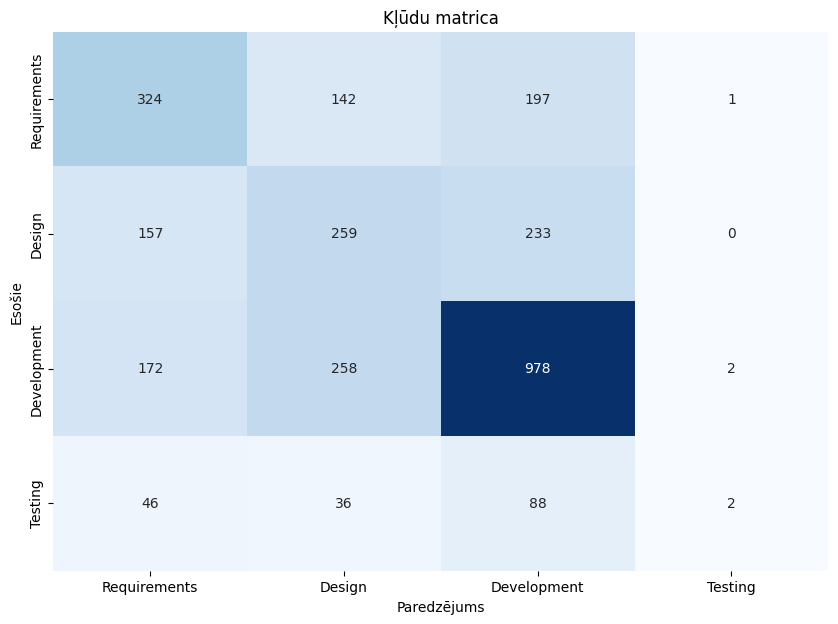

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Definējam teksta vērtībām atbilstošās skaitliskās vērtības.
categories = {
    'Requirements': 0,
    'Design': 1,
    'Development': 2,
    'Testing': 3
}

# Veidojma kļūdu matricu
plt.figure(figsize=(10, 7))
sns.heatmap(overall_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories.keys(), yticklabels=categories.keys(), cbar=False)

# Definējam nosaukumus
plt.xlabel('Paredzējums')
plt.ylabel('Esošie')
plt.title('Kļūdu matrica')
plt.show()

In [4]:
# Paredzējums
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

loaded_model = load_model('./drive/MyDrive/ColabNotebooks/TrainedModel/RNN_CV_Without_Smote_Cikls_5.keras')

def predictPhase(bugText):
  # Pārveidojam kategorijas uz skaitļu vērtībām
  categories = {
      'Requirements': 0,
      'Design': 1,
      'Development': 2,
      'Testing': 3
  }
  # Pārveidojam skaitļu vērtības uz teksta vērtībām
  reverse_categories = {v: k for k, v in categories.items()}

  # Veicam teksta sadalīšanu marķieros
  input_sequence = tokenizer.texts_to_sequences([bugText])
  input_padded = pad_sequences(input_sequence, padding='post')

  prediction = np.argmax(model.predict(input_padded), axis=1)[0]
  return reverse_categories[prediction]


defect_Description_for_prediction = 'database title column type must be changed to integer'

predict_phase = predictPhase(defect_Description_for_prediction)
print(f"Defekta apraksts '{defect_Description_for_prediction}' attiecas uz '{predict_phase}' fāzi.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Defekta apraksts 'database title column type must be changed to integer' attiecas uz 'Development' fāzi.
